In [2]:
pip install holidays lightgbm

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.0 MB/s eta 0:00:00:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [40]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import holidays
import dateutil.easter as easter
import time

# from Help_Funs import smape, is_holiday

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import KFold

from lightgbm import LGBMRegressor
import tensorflow as tf


s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/Tabular-Playground-Sep-2022/train.csv'
file_key_2 = 'Tabular-Playground-Series/Tabular-Playground-Sep-2022/test.csv'
file_key_3 = 'Tabular-Playground-Series/Tabular-Playground-Sep-2022/sample_submission.csv'
file_key_4 = 'Tabular-Playground-Series/Tabular-Playground-Sep-2022/TPSSEP22_GDP_data_2017_to_2021.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

bucket_object_4 = bucket.Object(file_key_4)
file_object_4 = bucket_object_4.get()
file_content_stream_4 = file_object_4.get('Body')

## Reading data-files
train = pd.read_csv(file_content_stream_1)
train['date'] = pd.to_datetime(train['date'], format = '%Y-%m-%d')

test = pd.read_csv(file_content_stream_2)
test['date'] = pd.to_datetime(test['date'], format = '%Y-%m-%d')

submission = pd.read_csv(file_content_stream_3)
country_gdp = pd.read_csv(file_content_stream_4)
df_gdp_all = country_gdp.groupby('year')['GDP'].sum().reset_index()

train_df = train
original_train_df = train_df.copy()
test_df = test
train_df.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [41]:
for df in [train_df, test_df]:
    df['product'] = df['product'].str.replace(' ', '_')
    df['product'] = df['product'].str.replace(':', '_')

In [42]:
store_weights = train_df.groupby('store')['num_sold'].sum() / train_df['num_sold'].sum()
store_weights

store
KaggleMart    0.742515
KaggleRama    0.257485
Name: num_sold, dtype: float64

In [43]:
product_df = train_df.groupby(['date', 'product'])['num_sold'].sum().reset_index()
product_df.head()

,date,product,num_sold
0,2017-01-01,Kaggle_Advanced_Techniques,4267
1,2017-01-01,Kaggle_Getting_Started,3492
2,2017-01-01,Kaggle_Recipe_Book,2900
3,2017-01-01,Kaggle_for_Kids__One_Smart_Goose,4693
4,2017-01-02,Kaggle_Advanced_Techniques,3242


In [44]:
product_ratio_df = product_df.pivot(index = 'date', columns = 'product', values = 'num_sold')
product_ratio_df = product_ratio_df.apply(lambda x: x / x.sum(), axis = 1)
product_ratio_df = product_ratio_df.stack().rename('ratios').reset_index()
product_ratio_df

,date,product,ratios
0,2017-01-01,Kaggle_Advanced_Techniques,0.277944
1,2017-01-01,Kaggle_Getting_Started,0.227462
2,2017-01-01,Kaggle_Recipe_Book,0.188900
3,2017-01-01,Kaggle_for_Kids__One_Smart_Goose,0.305693
4,2017-01-02,Kaggle_Advanced_Techniques,0.280014
...,...,...,...
5839,2020-12-30,Kaggle_for_Kids__One_Smart_Goose,0.300929
5840,2020-12-31,Kaggle_Advanced_Techniques,0.291703
5841,2020-12-31,Kaggle_Getting_Started,0.221948
5842,2020-12-31,Kaggle_Recipe_Book,0.193823


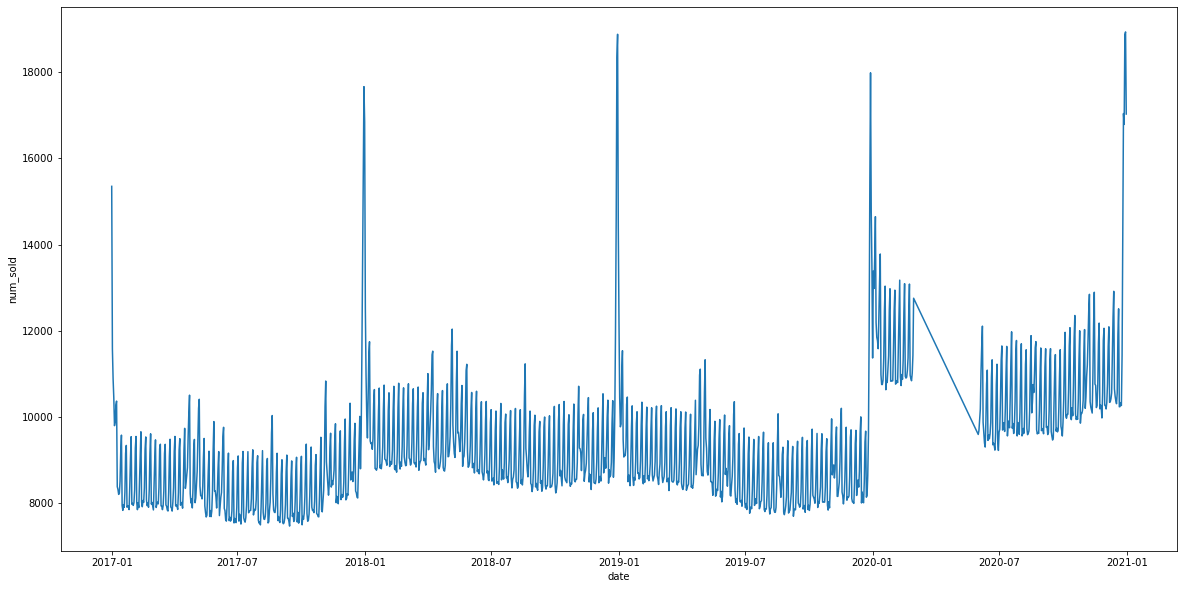

In [45]:
train_df = train_df.groupby(['date'])['num_sold'].sum().reset_index()

weekly_df = train_df.groupby([pd.Grouper(key = 'date', freq = 'W')])['num_sold'].sum().rename('num_sold').reset_index()
monthly_df = train_df.groupby([pd.Grouper(key = 'date', freq = 'MS')])['num_sold'].sum().rename('num_sold').reset_index()

train_nocovid_df = train_df.loc[~((train_df['date'] >= '2020-03-01') & (train_df['date'] < '2020-06-01'))]
f, ax = plt.subplots(figsize = (20,10))
sns.lineplot(data = train_nocovid_df, x = 'date', y = 'num_sold');

In [46]:
train_df = train_nocovid_df

## get the dates to forecast for
test_all_df = test_df.groupby(['date'])['row_id'].first().reset_index().drop(columns = 'row_id')

## keep dates for later
test_all_df_dates = test_all_df[['date']]

In [47]:
def feature_engineer(df):
    new_df = df.copy()
    new_df["month"] = df["date"].dt.month
    new_df["month_sin"] = np.sin(new_df['month'] * (2 * np.pi / 12))
    #new_df["month_cos"] = np.cos(new_df['month'] * (2 * np.pi / 12))
    
    new_df["day"] = df["date"].dt.day
    new_df["day_sin"] = np.sin(new_df['day'] * (2 * np.pi / 12))
    #new_df["day_cos"] = np.cos(new_df['day'] * (2 * np.pi / 12))
    
    new_df["day_of_week"] = df["date"].dt.dayofweek
    new_df["day_of_week"] = new_df["day_of_week"].apply(lambda x: 0 if x<=3 else(1 if x==4 else (2 if x==5 else (3))))
    
    new_df["day_of_year"] = df["date"].dt.dayofyear

    new_df["day_of_year"] = new_df.apply(lambda x: x["day_of_year"]-1 if (x["date"] > pd.Timestamp("2020-02-29") and x["date"] < pd.Timestamp("2021-01-01"))  else x["day_of_year"], axis=1)
    
    important_dates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 124, 125, 126, 127, 140, 141, 167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 
                       180, 181, 203, 230, 231, 232, 233, 234, 282, 289, 290, 307, 308, 309, 310, 311, 312, 313, 317, 318, 319, 320, 360, 361, 362, 363, 364, 365]
    

    new_df["important_dates"] = new_df["day_of_year"].apply(lambda x: x if x in important_dates else 0)
    #new_df["important_dates"] = new_df["day_of_year"].apply(lambda x: x if x in [1,2,3,4,5,6,7,8,125,126,360,361,362,363,364,365] else 0)
    
    
    new_df["year"] = df["date"].dt.year
    #new_df['is_pandemic_year'] = new_df['year'].astype(int) >= 2020
    '''
    easter_date = new_df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"easter{d}": 
                                      (df.date - easter_date == np.timedelta64(d, "D"))
                                      for d in list(range(-2, 11)) + list(range(40, 48)) + list(range(51, 58))})],
                       axis=1)
    '''
    
    easter_date = new_df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    for day in list(range(-5, 5)) + list(range(40, 48)):
        new_df[f'easter_{day}'] = (new_df.date - easter_date).dt.days.eq(day)
    new_df = new_df.drop(columns=["date","month","day", "day_of_year"])
    
    for col in new_df.columns :
        if 'easter' in col :
            new_df = pd.get_dummies(new_df, columns = [col], drop_first=True)
    
    new_df = pd.get_dummies(new_df, columns = ["important_dates","day_of_week"], drop_first=True)
    
    return new_df

In [48]:
def get_holidays(df):
    years_list = [2017, 2018, 2019, 2020, 2021]

    holiday_BE = holidays.CountryHoliday('BE', years = years_list)
    holiday_FR = holidays.CountryHoliday('FR', years = years_list)
    holiday_DE = holidays.CountryHoliday('DE', years = years_list)
    holiday_IT = holidays.CountryHoliday('IT', years = years_list)
    holiday_PL = holidays.CountryHoliday('PL', years = years_list)
    holiday_ES = holidays.CountryHoliday('ES', years = years_list)

    holiday_dict = holiday_BE.copy()
    holiday_dict.update(holiday_FR)
    holiday_dict.update(holiday_DE)
    holiday_dict.update(holiday_IT)
    holiday_dict.update(holiday_PL)
    holiday_dict.update(holiday_ES)

    df['holiday_name'] = df['date'].map(holiday_dict)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')
    
    return df

In [49]:
def encode_holiday_names(df, enc, subset='train'):
    if subset=='train':
        df['holiday_name'] = enc.fit_transform(df['holiday_name'].values.reshape(-1,1))
    else:
        df['holiday_name'] = enc.transform(df['holiday_name'].values.reshape(-1,1))
        not_hol_val = oe.transform([['Not Holiday']])[0,0]
        df.loc[df['holiday_name']==-1, 'holiday_name'] = not_hol_val
    return df

In [50]:
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

train_all_df = get_holidays(train_df)
test_all_df = get_holidays(test_all_df)

train_all_df = feature_engineer(train_all_df)
test_all_df = feature_engineer(test_all_df)

train_all_df = encode_holiday_names(train_all_df, oe)
test_all_df = encode_holiday_names(test_all_df, oe)

In [51]:
def smape(y_true, y_pred):
    smape = abs(y_true - y_pred) / (abs(y_true) + abs(y_pred))
    smape = smape.mean() * 200
    return smape

In [52]:
y = train_all_df["num_sold"]
X = train_all_df.drop(columns="num_sold")
X_test = test_all_df

In [53]:
X.head()

,holiday_name,is_holiday,month_sin,day_sin,year,easter_-5_True,easter_-4_True,easter_-3_True,easter_-2_True,easter_-1_True,easter_0_True,easter_1_True,easter_2_True,easter_3_True,easter_4_True,easter_40_True,easter_41_True,easter_42_True,easter_43_True,easter_44_True,easter_45_True,easter_46_True,easter_47_True,important_dates_1,important_dates_2,important_dates_3,important_dates_4,important_dates_5,important_dates_6,important_dates_7,important_dates_8,important_dates_9,important_dates_10,important_dates_11,important_dates_12,important_dates_124,important_dates_125,important_dates_126,important_dates_127,important_dates_140,important_dates_141,important_dates_167,important_dates_168,important_dates_169,important_dates_170,important_dates_171,important_dates_173,important_dates_174,important_dates_175,important_dates_176,important_dates_177,important_dates_178,important_dates_179,important_dates_180,important_dates_181,important_dates_203,important_dates_230,important_dates_231,important_dates_232,important_dates_233,important_dates_234,important_dates_282,important_dates_289,important_dates_290,important_dates_307,important_dates_308,important_dates_309,important_dates_310,important_dates_311,important_dates_312,important_dates_313,important_dates_317,important_dates_318,important_dates_319,important_dates_320,important_dates_360,important_dates_361,important_dates_362,important_dates_363,important_dates_364,important_dates_365,day_of_week_1,day_of_week_2,day_of_week_3
0,26.0,1,0.5,0.500000,2017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,3.0,1,0.5,0.866025,2017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,25.0,0,0.5,1.000000,2017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,25.0,0,0.5,0.866025,2017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,25.0,0,0.5,0.500000,2017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# LightGBM

In [ ]:
lightgbm_preds = np.zeros(X_test.shape[0])
avg_smape = 0
n=0

kf = GroupKFold(n_splits=4)

for trn_idx, test_idx in kf.split(X, groups = X.year) :
    x_train, x_valid = X.iloc[trn_idx], X.iloc[test_idx]
    y_train, y_valid = y.iloc[trn_idx], y.iloc[test_idx]
    
    model_lgb = LGBMRegressor(n_estimators = 5000, 
                              learning_rate = 0.01,
                              num_leaves = 40,
                              max_depth = 9, 
                              lambda_l1 = 3, 
                              lambda_l2 = 1, 
                              bagging_fraction = 0.95, 
                              feature_fraction = 0.96)

    linear_model.fit(x_train, y_train)

    y_pred = linear_model.predict(x_valid)
    avg_smape += smape(y_pred, y_valid)

    n = n + 1

    test_pred = linear_model.predict(X_test)
    pred = pd.Series(test_pred) 

    lightgbm_preds += pred / kf.n_splits  
    
print(f'smape: {avg_smape/kf.n_splits}')